specific token construction i.e. concatinate input and targets i.e. $e_i = (x_i,y_i)$.

In [67]:
import jax
import optax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from meta_icl.transformer import Transformer
from meta_icl.data import sample_regression_dataset

main_rng = jax.random.key(42)

lr = 3e-2
set_size = 10
input_size = 1
num_epochs = 500

model = Transformer(
    num_heads=1,
    key_size=2,
    num_layers=1,
    output_size=1,
    use_pe=False,
    use_layer_norm=False,
    use_softmax=True # Setting it to false means we follow the linear self attention like in the paper
)

# Initialization
x = jnp.ones((1, 11, 2))
params = model.init(main_rng, x, is_training=True) 
y = model.apply(params, x, is_training=True)

opt_adamw = optax.adamw(learning_rate=lr)
opt_params = opt_adamw.init(params)

# Training
def compute_mse_loss(params, model, X, y):
    # TODO: Compare slicing with original codebase
    y_hat = model.apply(params, X, is_training=True)[:, -1, -1] # inference
    loss = jnp.mean((y_hat - y[:, -1]) ** 2)  # MSE loss
    return loss

losses = []
for epoch in range(num_epochs):
    X, y, _ = sample_regression_dataset(main_rng, input_size, set_size=set_size, input_range=1.0)
    
    # TODO: Refactor step to a func with @jax.jit train_step()
    loss_grad_fn = jax.value_and_grad(compute_mse_loss)
    loss, grads = loss_grad_fn(params, model, X, y)

    updates, opt_params = opt_adamw.update(grads, opt_params, params)
    params = optax.apply_updates(params, updates)

    losses.append(float(loss))
    
    # Created new params, opt_params
    if epoch % 100 == 0:
        print(epoch, loss)

0 0.11954874
100 0.014147575
200 0.011313792
300 0.011123509
400 0.011102421


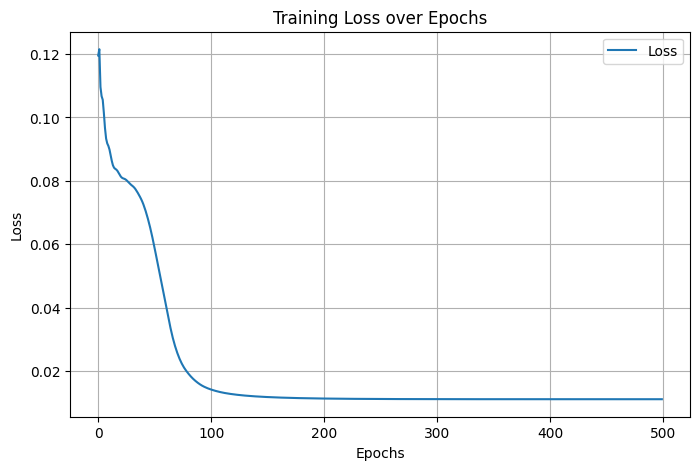

In [68]:
plt.figure(figsize=(8, 5))
plt.plot(range(num_epochs), losses, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid()
plt.show()

In [65]:
X[0]

Array([[ 0.32023227,  0.00576459],
       [ 0.41059542,  0.00739124],
       [ 0.16188133,  0.00291407],
       [ 0.45175338,  0.00813213],
       [-0.23948443, -0.00431102],
       [ 0.41738868,  0.00751352],
       [ 0.1675191 ,  0.00301556],
       [-0.18496227, -0.00332956],
       [ 0.23673987,  0.00426162],
       [-0.41973197, -0.00755571],
       [ 0.24938571, -0.        ]], dtype=float32)

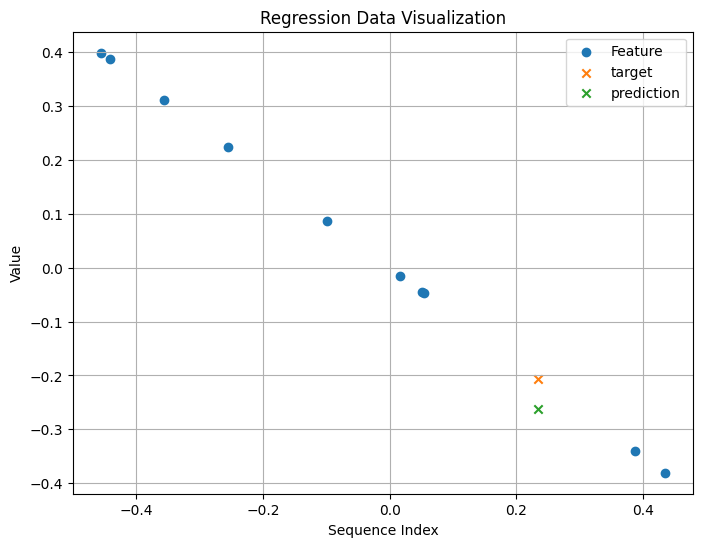

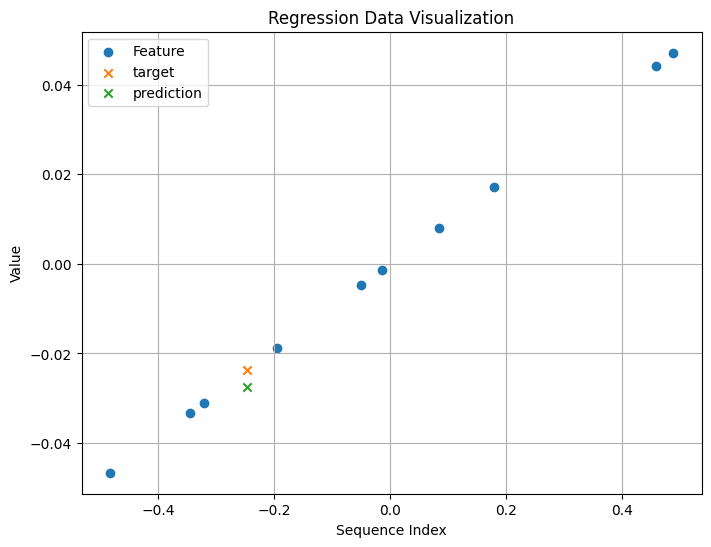

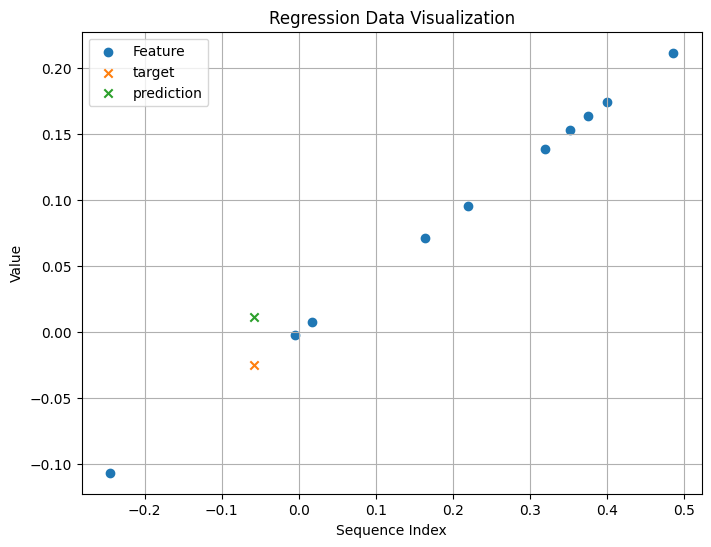

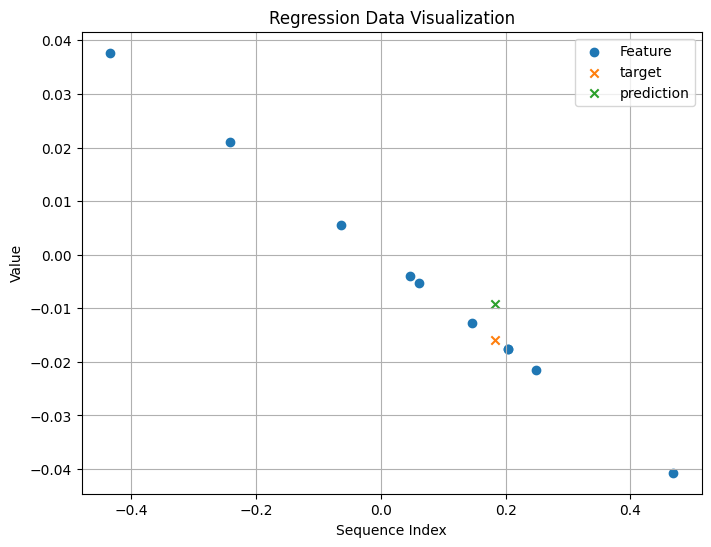

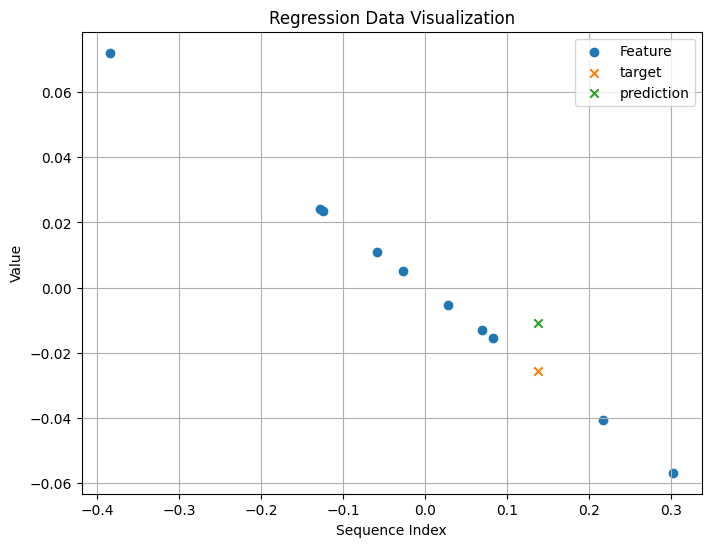

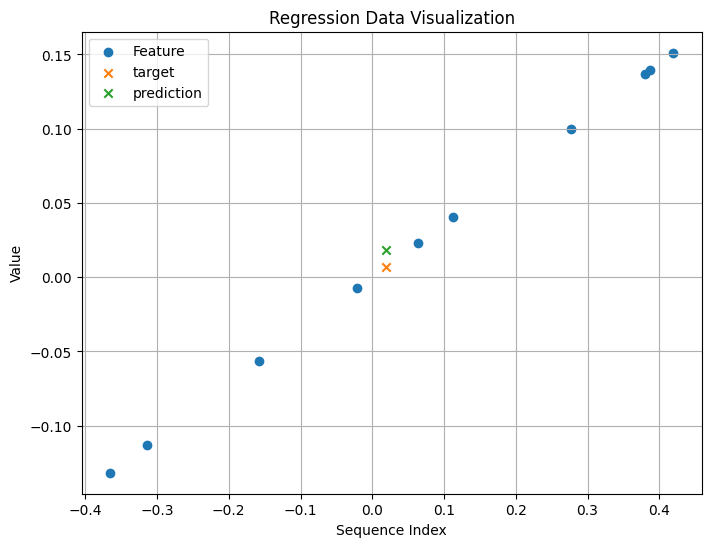

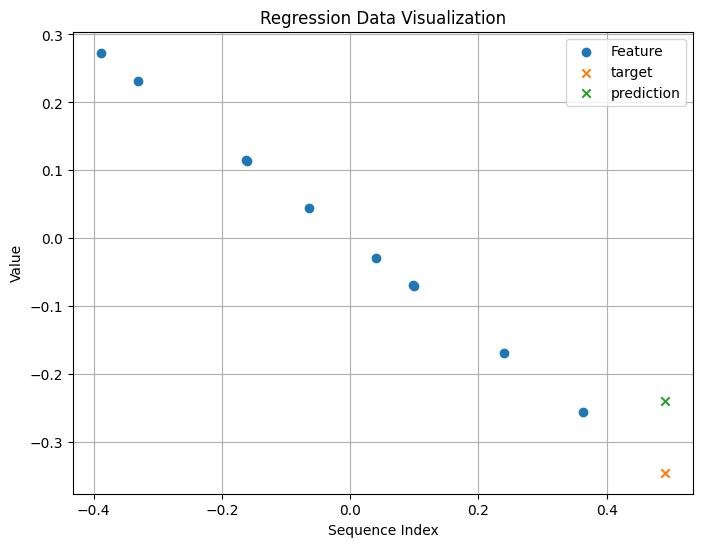

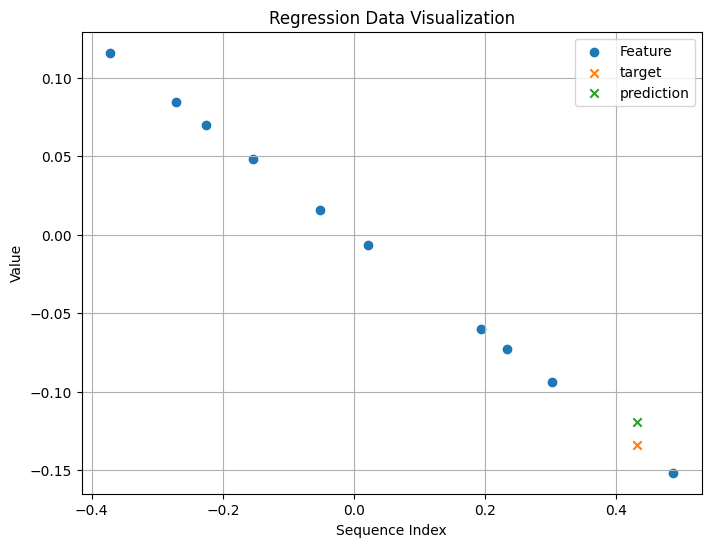

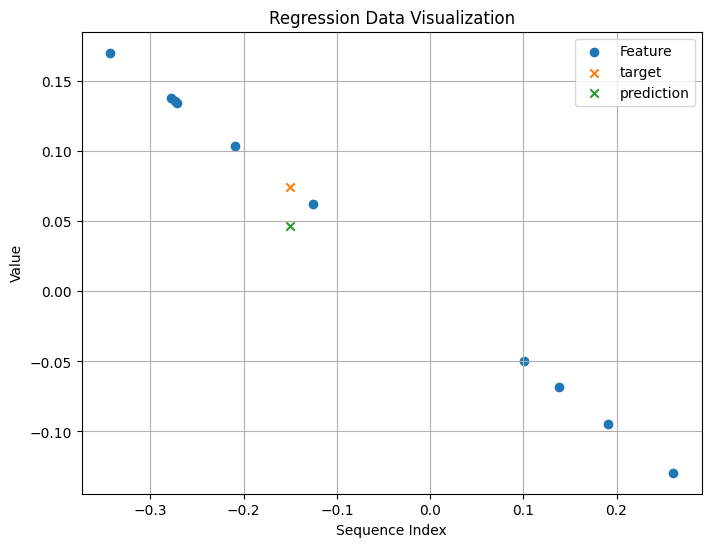

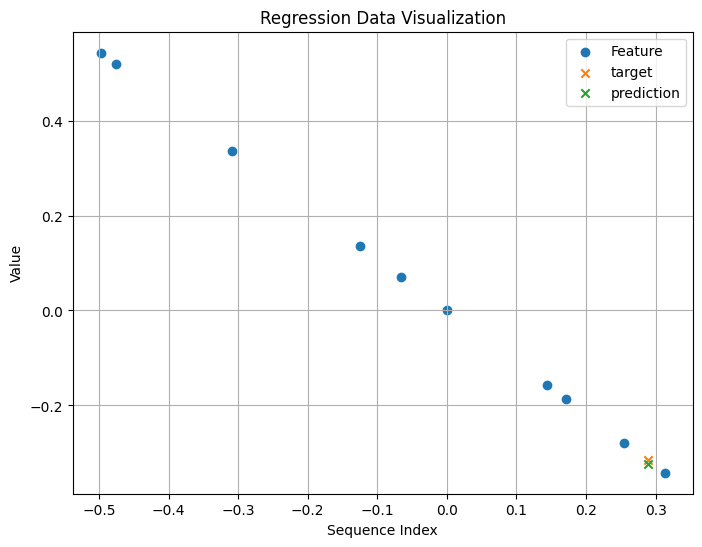

In [5]:
# Inspect example of the data
X, y, _ = sample_regression_dataset(jax.random.key(43), input_size=1, input_range=1.0)
for indice in range(0, 10):
    y_hat = model.apply(params, X, is_training=True)[:, -1, -1]
    
    # The 0.0 value is the target for the transformer
    plt.figure(figsize=(8, 6))
    plt.scatter(X[indice, :, 0][:-1], X[indice, :, 1][:-1], label='Feature', marker='o')
    plt.scatter(y[indice, 0], y[indice, 1], label='target', marker='x')
    plt.scatter(y[indice, 0], y_hat[indice], label='prediction', marker='x')
    plt.title('Regression Data Visualization')
    plt.xlabel('Sequence Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

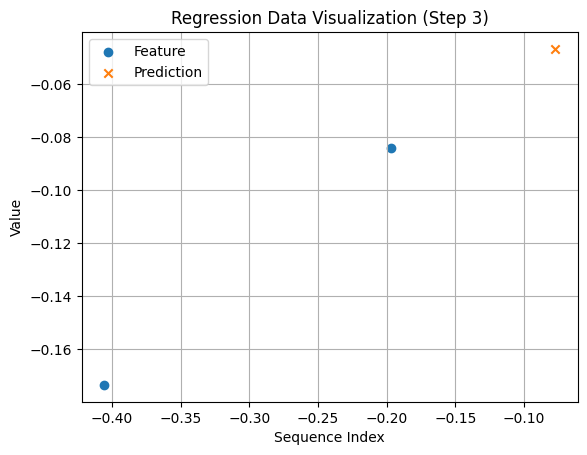

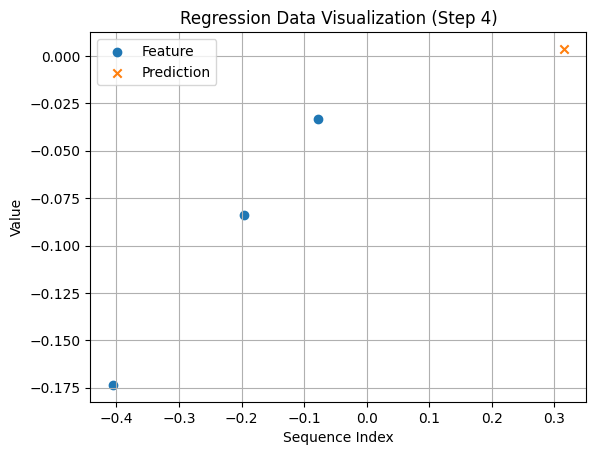

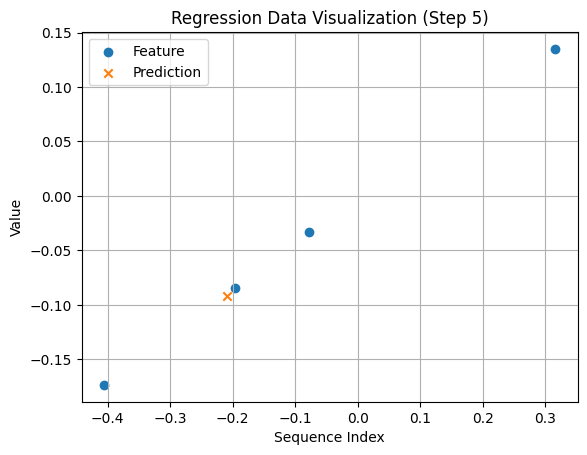

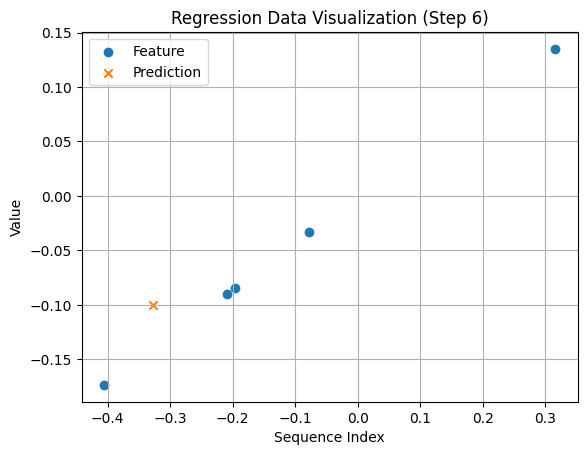

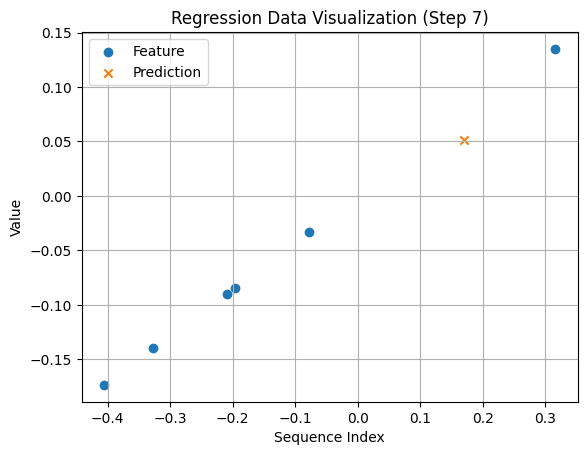

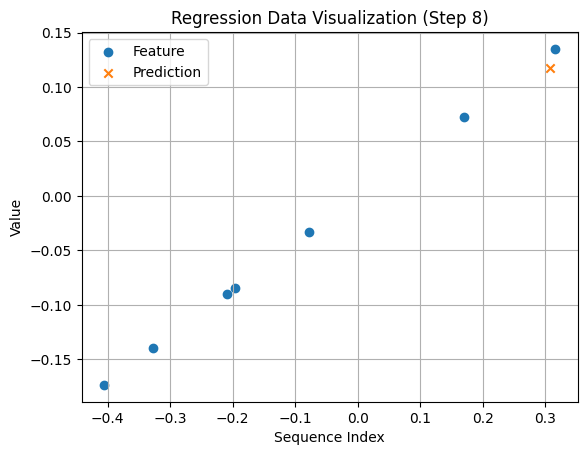

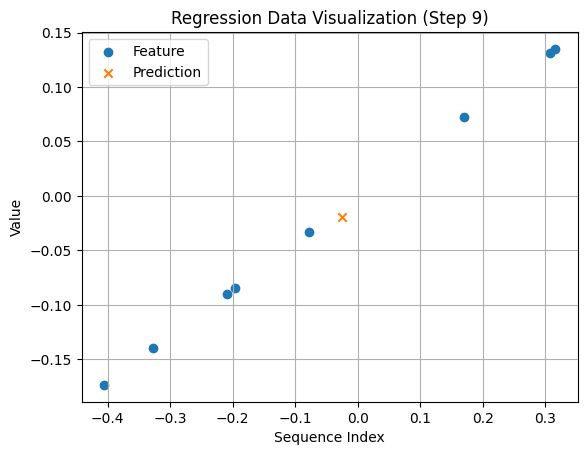

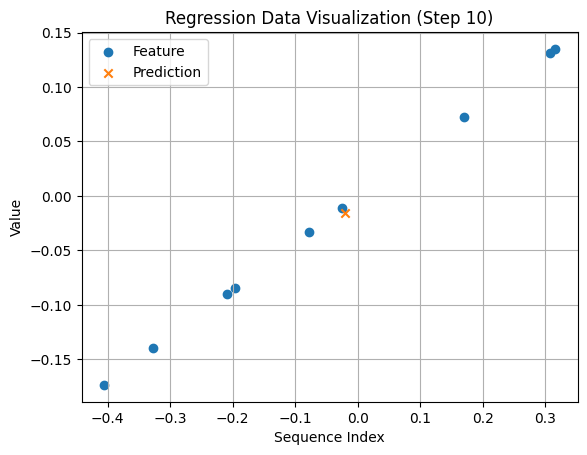

In [63]:
X, y, _ = sample_regression_dataset(jax.random.key(42), input_size=1, input_range=1.0)

indice = 10
for step in range(3, X.shape[1]):
    plt.clf()
    
    masked_X = X[indice, :step, :].copy()  
    plt.scatter(masked_X[:, 0][:step-1], masked_X[:, 1][:step-1], label='Feature', marker='o')

    # Mask out the last index corresponding to the y value
    masked_X = jnp.expand_dims(masked_X.at[-1, 1].set(0.0), 0)
    y_hat = model.apply(params, masked_X, is_training=True)[:, -1, -1]
    plt.scatter([masked_X[0, -1, 0]], y_hat, label='Prediction', marker='x')
    
    # Highlight the unmasked part
    plt.title(f'Regression Data Visualization (Step {step})')
    plt.xlabel('Sequence Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()